In [7]:
import sqlalchemy
import pyodbc
import pandas as pd
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import requests
import io
import processing_functions
from site_information_class import SiteDataProcessor
%matplotlib inline



Rounded coordinates for SITEID 15468: X=316500, Y=121500
Sump level analogue info for SITEID 15468:
Analogue Server: waste2
Analogue Signal: E7458
Spill(mm): nan
Pre-Spill (mm): nan
Flowmeter signal information for Site Id 15468:
Flowmeter Server: ['WASTE' 'WASTE2']
DB_ADDR: ['E7083' 'E7456']
DB_NAME: ['154680RISING MAIN FLOW' '15468ARISING MAIN FLOW AI']


In [8]:


# Function to load dataframes from xlsx files if they are not already loaded
def load_dataframes(site_id, start_date_str, end_date_str):
    df_raw_sump = None
    df_raw_flow_meter = None
    df_rainfall = None
    df_hour_agg_flow_meter = None
    df_daily_agg_sump = None

    try:
        df_raw_sump = pd.read_excel(f'../data/raw/site{site_id}_from_{start_date_str}_to_{end_date_str}_raw_sump.xlsx')
        print("Loaded df_raw_sump from xlsx file.")
    except FileNotFoundError:
        print("df_raw_sump xlsx file not found.")

    try:
        df_raw_flow_meter = pd.read_excel(f'../data/raw/site{site_id}_from_{start_date_str}_to_{end_date_str}_raw_flow_meter.xlsx')
        print("Loaded df_raw_flow_meter from xlsx file.")
    except FileNotFoundError:
        print("df_raw_flow_meter xlsx file not found.")

    try:
        df_rainfall = pd.read_excel(f'../data/raw/site{site_id}_from_{start_date_str}_to_{end_date_str}_rainfall.xlsx')
        print("Loaded df_rainfall from xlsx file.")
    except FileNotFoundError:
        print("df_rainfall xlsx file not found.")

    try:
        df_hour_agg_flow_meter = pd.read_excel(f'../data/raw/site{site_id}_from_{start_date_str}_to_{end_date_str}_hour_agg_flow_meter.xlsx')
        print("Loaded df_hour_agg_flow_meter from xlsx file.")
    except FileNotFoundError:
        print("df_hour_agg_flow_meter xlsx file not found.")

    try:
        df_daily_agg_sump = pd.read_excel(f'../data/raw/site{site_id}_from_{start_date_str}_to_{end_date_str}_daily_agg_sump.xlsx')
        print("Loaded df_daily_agg_sump from xlsx file.")
    except FileNotFoundError:
        print("df_daily_agg_sump xlsx file not found.")

    return df_raw_sump, df_raw_flow_meter, df_rainfall, df_hour_agg_flow_meter, df_daily_agg_sump

# Example usage
site_id = 14035
start_date_str = "2023-01-03"
end_date_str = "2023-01-05"

df_raw_sump, df_raw_flow_meter, df_rainfall, df_hour_agg_flow_meter, df_daily_agg_sump = load_dataframes(site_id, start_date_str, end_date_str)


Loaded df_raw_sump from xlsx file.
df_raw_flow_meter xlsx file not found.
Loaded df_rainfall from xlsx file.
Loaded df_hour_agg_flow_meter from xlsx file.
df_daily_agg_sump xlsx file not found.


In [9]:
# Print the head(5) of each dataframe and save to xlsx
if df_raw_sump is not None:
    print("Head of df_raw_sump:")
    print(df_raw_sump.head(5))



Head of df_raw_sump:
              TimeGMT       date  SourceSystemId  DbAddr        DbName  \
0 2023-01-03 00:00:00 2023-01-03               1   51467  Default Name   
1 2023-01-03 00:01:00 2023-01-03               1   51467  Default Name   
2 2023-01-03 00:02:00 2023-01-03               1   51467  Default Name   
3 2023-01-03 00:03:00 2023-01-03               1   51467  Default Name   
4 2023-01-03 00:04:00 2023-01-03               1   51467  Default Name   

      EValue  Year  Month  Day  
0  26.900000  2023      1    3  
1  27.075001  2023      1    3  
2  26.025000  2023      1    3  
3  24.275000  2023      1    3  
4  22.625000  2023      1    3  


In [10]:
if df_hour_agg_flow_meter is not None:
    print("Head of df_hour_agg_flow_meter:")
    print(df_hour_agg_flow_meter.head(5))

Head of df_hour_agg_flow_meter:
   Hour  DbAddr  count  meanEValue  stddev_EValue  Year  Month  Day
0     0   50018     60       97.37      31.284332  2023      1    3
1     1   50018     60       82.50      43.062477  2023      1    3
2     2   50018     60       85.27      42.184485  2023      1    3
3     3   50018     60       77.12      43.510123  2023      1    3
4     4   50018     60       79.47      43.558350  2023      1    3


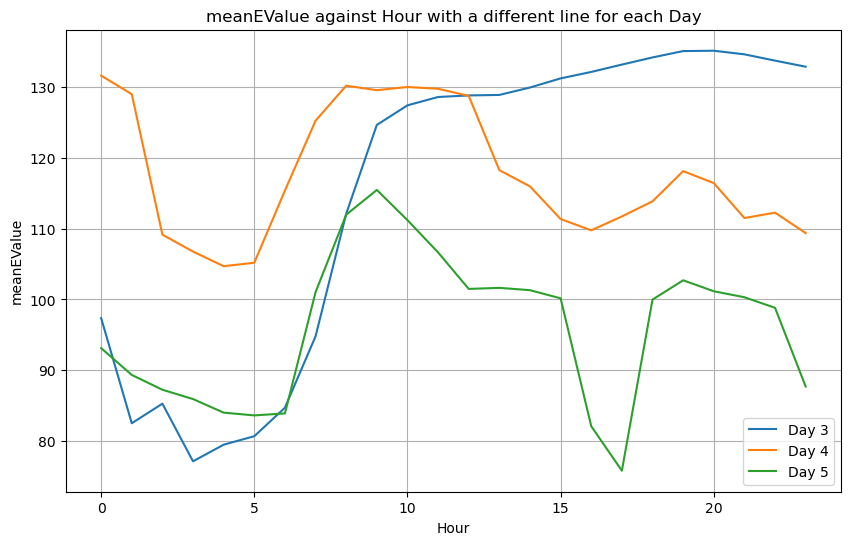

In [11]:
def plot_meanEValue(df):
    """
    Plots 'meanEValue' against 'Hour' with a different line for each 'Day' in the given dataframe.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data with columns 'Hour', 'DbAddr', 'count', 'meanEValue', 
                       'stddev_EValue', 'Year', 'Month', 'Day'
    """
    plt.figure(figsize=(10,6))
    for day in df['Day'].unique():
        day_data = df[df['Day'] == day]
        plt.plot(day_data['Hour'], day_data['meanEValue'], label=f'Day {day}')

    plt.xlabel('Hour')
    plt.ylabel('meanEValue')
    plt.title('meanEValue against Hour with a different line for each Day')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_meanEValue(df_hour_agg_flow_meter)

In [32]:
if df_raw_flow_meter is not None:
    print("Head of df_raw_flow_meter:")
    print(df_raw_flow_meter.head(5))


In [34]:

if df_rainfall is not None:
    print("Head of df_rainfall:")
    print(df_rainfall.head(5))
df_rainfall['timestamp'] = pd.to_datetime(df_rainfall['ReadingDate'], format='%Y%m%d%H%M')
print(df_rainfall.head(5))

Head of df_rainfall:
    ReadingDate  Easting  Northing  Intensity(mm/hr)  Depth(mm)  Year  Month  \
0  202301031735   418500     93500              0.01       0.16  2023      1   
1  202301031730   418500     93500              0.08       0.94  2023      1   
2  202301031725   418500     93500              0.05       0.66  2023      1   
3  202301031720   418500     93500              0.06       0.75  2023      1   
4  202301031715   418500     93500              0.05       0.66  2023      1   

   Day  
0    3  
1    3  
2    3  
3    3  
4    3  
    ReadingDate  Easting  Northing  Intensity(mm/hr)  Depth(mm)  Year  Month  \
0  202301031735   418500     93500              0.01       0.16  2023      1   
1  202301031730   418500     93500              0.08       0.94  2023      1   
2  202301031725   418500     93500              0.05       0.66  2023      1   
3  202301031720   418500     93500              0.06       0.75  2023      1   
4  202301031715   418500     93500          

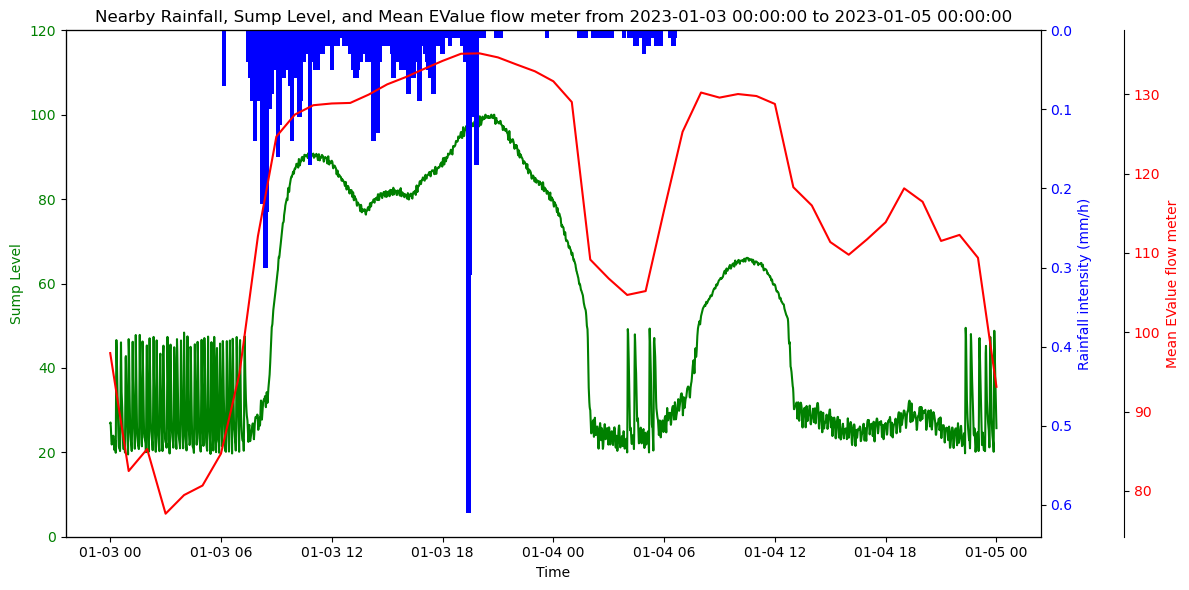

In [42]:
from IPython.display import display, clear_output
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
import processing_functions


start_time_plot = "2023-01-03 00:00:00"
end_time_plot = "2023-01-05 00:00:00"


df_sump_filtered = df_raw_sump
df_rainfall_filtered = df_rainfall
df_hour_agg_flow_meter_filtered = df_hour_agg_flow_meter

def plot_rainfall_mean_agg_flow_meter_and_raw_sump_level(start_time, end_time, df_raw_sump, df_rainfall, df_hour_agg_flow_meter, sump_ylim=None):
    # Convert start and end times to datetime
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)

    # Filter the dataframes based on the specified time interval
    df_sump_filtered = df_raw_sump[(df_raw_sump["TimeGMT"] >= start_time) & (df_raw_sump["TimeGMT"] <= end_time)]
    df_rainfall_filtered = df_rainfall[(df_rainfall["timestamp"] >= start_time) & (df_rainfall["timestamp"] <= end_time)]
    df_hour_agg_flow_meter_filtered = df_hour_agg_flow_meter[
        (pd.to_datetime(df_hour_agg_flow_meter["Year"].astype(str) + '-' + df_hour_agg_flow_meter["Month"].astype(str) + '-' + df_hour_agg_flow_meter["Day"].astype(str) + ' ' + df_hour_agg_flow_meter["Hour"].astype(str) + ':00:00') >= start_time) & 
        (pd.to_datetime(df_hour_agg_flow_meter["Year"].astype(str) + '-' + df_hour_agg_flow_meter["Month"].astype(str) + '-' + df_hour_agg_flow_meter["Day"].astype(str) + ' ' + df_hour_agg_flow_meter["Hour"].astype(str) + ':00:00') <= end_time)
    ]

    # Sort the filtered dataframes by their respective time columns
    df_sump_filtered = df_sump_filtered.sort_values(by="TimeGMT")
    df_rainfall_filtered = df_rainfall_filtered.sort_values(by="timestamp")
    df_hour_agg_flow_meter_filtered = df_hour_agg_flow_meter_filtered.sort_values(by=["Year", "Month", "Day", "Hour"])

    # Create a figure and axis objects
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot sump level on the first y-axis
    ax1.plot(df_sump_filtered["TimeGMT"], df_sump_filtered["EValue"], color='green', label='Sump Level')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Sump Level', color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    # Apply user-defined axis range if provided
    if sump_ylim:
        ax1.set_ylim(sump_ylim)

    # Create a second y-axis for rainfall
    ax2 = ax1.twinx()
    ax2.bar(df_rainfall_filtered["timestamp"], df_rainfall_filtered["Intensity(mm/hr)"], color='blue', label='Rainfall', width=0.01)
    ax2.set_ylabel('Rainfall intensity (mm/h)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.invert_yaxis()  # Reverse the y-axis for rainfall

    # Create a third y-axis for meanEValue
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis to the right
    ax3.plot(
        pd.to_datetime(df_hour_agg_flow_meter_filtered["Year"].astype(str) + '-' + df_hour_agg_flow_meter_filtered["Month"].astype(str) + '-' + df_hour_agg_flow_meter_filtered["Day"].astype(str) + ' ' + df_hour_agg_flow_meter_filtered["Hour"].astype(str) + ':00:00'), 
        df_hour_agg_flow_meter_filtered["meanEValue"], color='red', label='Mean EValue'
    )
    ax3.set_ylabel('Mean EValue flow meter', color='red')
    ax3.tick_params(axis='y', labelcolor='red')

    # Add title and remove horizontal grid lines
    plt.title(f'Nearby Rainfall, Sump Level, and Mean EValue flow meter from {start_time} to {end_time}')
    ax1.grid(False)  # Remove horizontal grid lines from the first y-axis
    ax2.grid(False)  # Remove horizontal grid lines from the second y-axis
    ax3.grid(False)  # Remove horizontal grid lines from the third y-axis

    fig.tight_layout()

    # Show the plot
    plt.show()


sump_ylim = (0, 120)
# Example usage
#processing_functions.plot_rainfall_mean_agg_flow_meter_and_raw_sump_level(start_time_plot, end_time_plot, df_sump_filtered, df_rainfall_filtered, df_hour_agg_flow_meter_filtered)
plot_rainfall_mean_agg_flow_meter_and_raw_sump_level(start_time_plot, end_time_plot, df_raw_sump, df_rainfall, df_hour_agg_flow_meter, sump_ylim)

In [9]:
# Runs the above function given the timeframe to produce a time series plot


#plot_rainfall_and_sump_level(start_time_plot, end_time_plot)

